# Physical Layer Abstraction

In this notebook, you will learn how to bypass the simulation of time-consuming physical
layer (PHY) procedures, such as MIMO detection and decoding, via [physical layer
abstraction](https://nvlabs.github.io/sionna/sys/api/abstraction.html).

Specifically, we will demonstrate how to abstract PHY computations for each user by
  - Aggregating the per-stream SINR values into a single, AWGN-equivalent effective
    SINR value;
  - Mapping the effective SINR value to a transport block error rate (TBLER)
    using pre-computed look-up tables from the forward error correction (FEC)
    module of Sionna PHY.
  
This method enables the fast computation of the transmission rate and HARQ feedback on
a per-user basis, allowing system-level simulations to scale up to tens of base stations and hundreds
of users, as demonstrated in the related [system-level simulation notebook](https://nvlabs.github.io/sionna/sys/tutorials/End-to-End_Example.html).

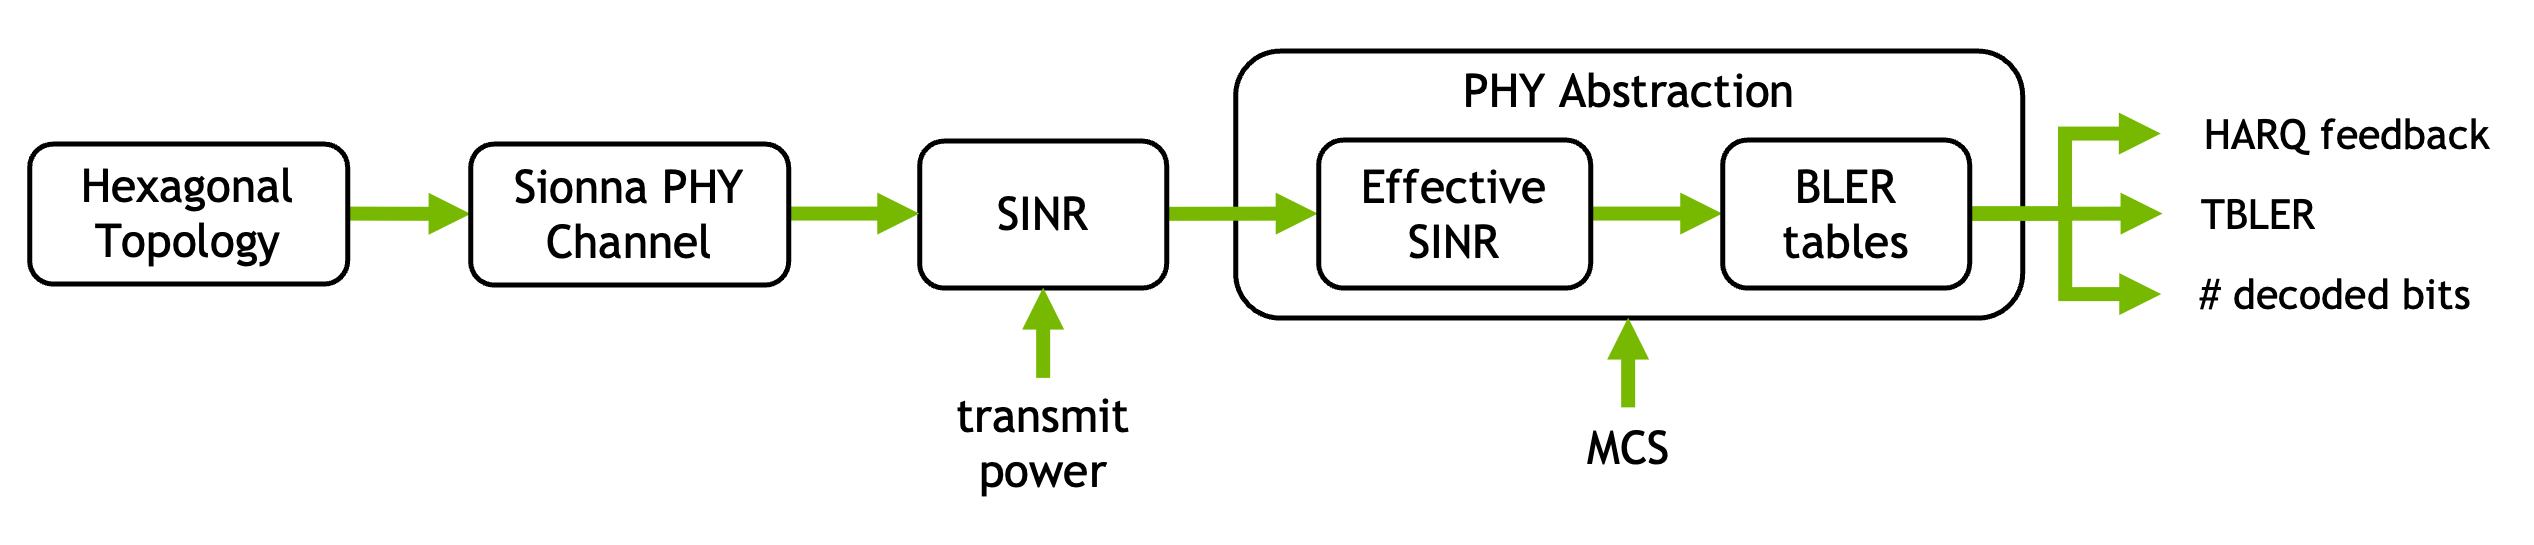

## Imports
We start by importing Sionna and the relevant external libraries.

In [15]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    if gpu_num!="":
        print(f'\nUsing GPU {gpu_num}\n')
    else:
        print('\nUsing CPU\n')
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna.sys
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [16]:
# Additional external libraries
import numpy as np
import matplotlib.pyplot as plt

# Sionna components
from sionna.phy.utils import log2, insert_dims, db_to_lin
from sionna.phy.constants import BOLTZMANN_CONSTANT
from sionna.phy.channel import subcarrier_frequencies, cir_to_ofdm_channel
from sionna.phy.channel.tr38901 import UMi, UMa, RMa, PanelArray
from sionna.phy.mimo import StreamManagement
from sionna.sys import PHYAbstraction, InnerLoopLinkAdaptation
from sionna.phy import config

# Internal computational precision
sionna.phy.config.precision = 'single'  # 'single' or 'double'

# Set random seed for reproducibility
sionna.phy.config.seed = 45

## Instantiate a PHYAbstraction object

By instantiating a [PHYAbstraction](https://nvlabs.github.io/sionna/sys/api/abstraction.html#sionna.sys.PHYAbstraction) object, precomputed effective SINR-to-BLER
tables are loaded for each available modulation and coding scheme (MCS) index.  
More information about MCS can be found in the documentation of the [5G NR
Transport Block](https://nvlabs.github.io/sionna/phy/api/nr.html#sionna.phy.nr.TBConfig).

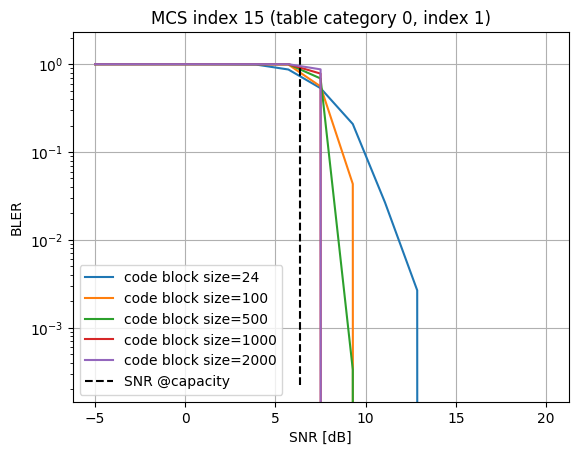

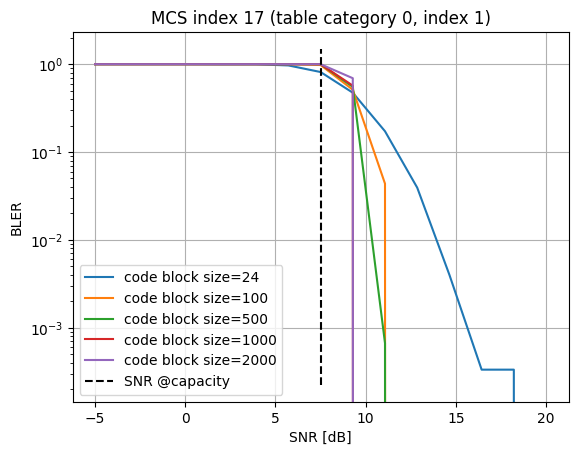

In [17]:
# Instantiate a PHYAbstraction object
phy_abs = PHYAbstraction()

mcs_category = 0  # 0 for uplink, 1 for downlink
mcs_table_index = 1  # Table index: [1,2] for UL, [1,2,3,4] for DL
mcs_index = 15  # MCS index

# Plot a BLER table
_ = phy_abs.plot(plot_subset={
    'category':
    {mcs_category: {'index':
                    {mcs_table_index:
                     {'MCS': [mcs_index, mcs_index+2]}}}}},  # MCS index
    show=True)

As can be seen from the figure above, the BLER depends not only depend on the
MCS but also on the code block size (CBS). The longer the code, the lower the BLER.

## Retrieve BLER values from interpolated tables

When a [PHYAbstraction](https://nvlabs.github.io/sionna/sys/api/abstraction.html#sionna.sys.PHYAbstraction) class is instantiated, the precomputed tables are interpolated over a fine
two-dimensional grid of SINR and code block size (CBS) values. These
interpolated tables are then used to obtain the BLER for different values of
SINR and CBS. 

The following code snippet shows this operation in detail. In
general, you are not supposed to call this method directly, but rather use the
`call` method of the `PHYAbstraction` class which does this for you, as shown
later on.

This method also returns the transport block error rate (TBLER), which is the
probability that at least one code block in a transport block is not decoded
correctly.




In [18]:
# Define the SNR and CB size at which BLER is retrieved
snr_eff_db = 9
cb_size = 80

# Compute the corresponding indices for the BLER interpolated table
snr_db_idx = phy_abs.get_idx_from_grid(snr_eff_db, 'snr')
cbs_idx = phy_abs.get_idx_from_grid(cb_size, 'cbs')

# Retrieve the interpolated BLER value
bler = phy_abs.bler_table_interp[mcs_category,
                                 mcs_table_index - 1,
                                 mcs_index,
                                 cbs_idx,
                                 snr_db_idx]

print(f'The BLER for MCS {mcs_index} at SNR {snr_eff_db} dB and CB size {cb_size} is {bler.numpy():.4f}')

The BLER for MCS 15 at SNR 9 dB and CB size 80 is 0.0511


## Generate a new BLER table

Optionally, in addition to or as a replacement for the pre-computed BLER tables that are shipped
with Sionna SYS, it is possible to generate new BLER tables at specified MCS indices, SNR and
code block size values.  
This might also be useful, if you want experiment with different type of
decoders.  

For more details, see the documentation of the
[new_bler_table](https://nvlabs.github.io/sionna/sys/api/abstraction.html#sionna.sys.PHYAbstraction.new_bler_table)
method and/or its source code.

In [19]:
# Define MCS indices at which the new BLER table is simulated
sim_set = {'category': {
    1:  # 0 for PUSCH, 1 for PDSCH
    {'index': {
        2: {'MCS': [16]}
    }}}}

# SINR and Code Block size values at which new simulations are performed
sinr_dbs = np.linspace(5, 25, 25)
cb_sizes = [24, 200, 3000]

# Compute new BLER tables
new_table = phy_abs.new_bler_table(
    sinr_dbs,
    cb_sizes,
    sim_set,
    max_mc_iter=15,  # max n. Monte-Carlo iterations per SNR points
    batch_size=10,
    verbose=True)


BLER simulations started. 
Total # (category, index, MCS, SINR) points to simulate: 3


Simulating category=1, index=2, CBS=24, MCS=16...

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
   -1.246 | 2.6222e-01 | 1.0000e+00 |         944 |        3600 |          150 |         150 |         0.8 |reached max iterations
   -0.412 | 2.5417e-01 | 9.8667e-01 |         915 |        3600 |          148 |         150 |         0.4 |reached max iterations
    0.421 | 2.4778e-01 | 9.9333e-01 |         892 |        3600 |          149 |         150 |         0.5 |reached max iterations
    1.254 | 2.1000e-01 | 1.0000e+00 |         756 |        3600 |          150 |         150 |         0.5 |reached max iterations
    2.088 | 2.0056e-01 | 9.8667e-01 |         722 |        3600 |          148 | 

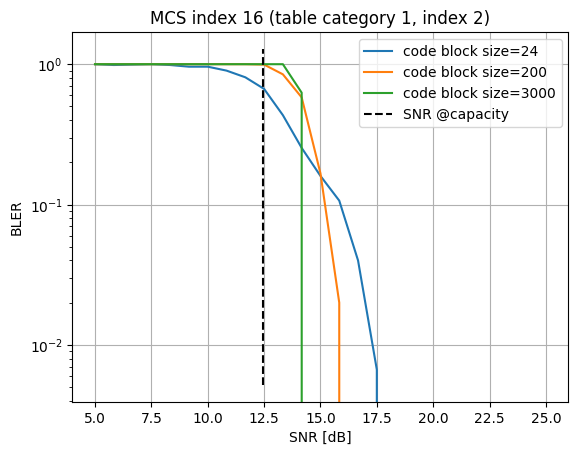

In [20]:
# Plot the new BLER table
phy_abs.plot(plot_subset=sim_set,
             show=True);

Please note that the new BLER table is overwritten to `phy_abs.bler_table` at
the corresponding entries.
We can also inspect the BLER table directly:

In [21]:
new_table["category"][1]["index"][2]["MCS"][16]["CBS"][200]

{'BLER': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9933333396911621,
  0.846666693687439,
  0.5799999833106995,
  0.1666666716337204,
  0.019999999552965164,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]}

## Bypass physical layer computations

Once the `PHYAbstraction` object has been instantiated, we can use it to
produce 
- Number of succesfully decoded bits;
- Hybrid automatic repeat request (HARQ) value, reporting an ACK (HARQ=1) or a NACK (HARQ=0) depending on whether the transport block has been correctly received. If missing, -1 is reported;
- Effective SINR value, that can be used as a measure of the channel condition quality for the user;
- Block error rate (BLER), defining the probability that a code block is not decoded correctly;
- Transport block error rate (TBLER), being the probability that at least one
  code block in a transport block is not decoded correctly. 

We first set up the main parameters:

In [22]:
# MCS table index
# Ranges within [1;4] for downlink and [1;2] for uplink, as in TS 38.214
mcs_table_index = 1

direction = 'uplink'  # 'downlink' or 'uplink'
mcs_category = int(direction == 'downlink')
num_ut = 80

# Time/frequency resource grid
num_ofdm_symbols = 14
num_subcarriers = 1024
num_streams_per_ut = 1

# BLER target value
bler_target = .1

Next we generate the SINR on a per-stream basis in random fashion.  
In subsequent tutorials you will learn how to generate more realistic SINR values based on
stochastic channel models or ray tracing.

In [23]:
# Generate random SINR values across UT
# Target shape:
# […, num_ofdm_symbols, num_subcarriers, num_ut, num_streams_per_ut]
sinr_db = config.tf_rng.uniform([1,1,num_ut,1], minval=-5, maxval=30)

# Generate random SINR values across UT, subcarriers, and OFDM symbols
sinr_db = sinr_db + config.tf_rng.normal(
    [num_ofdm_symbols, num_subcarriers, num_ut, num_streams_per_ut], mean=0, stddev=2)
sinr = db_to_lin(sinr_db)

To bypass the physical layer, the `PHYAbstraction` module also needs the MCS
indices for each user.  
For simplicity, we select it as the highest MCS index guaranteeing a TBLER not exceeding
the specified target value, via the link adaptation module
[InnerLoopLinkAdaptation (ILLA)](https://nvlabs.github.io/sionna/sys/api/link_adaptation.html#sionna.sys.InnerLoopLinkAdaptation).

In [24]:
illa = InnerLoopLinkAdaptation(phy_abs, bler_target)

mcs_index = illa(sinr=sinr,
                 mcs_table_index=mcs_table_index)
print("MCS indices: ",mcs_index.numpy())

MCS indices:  [14 18 10  5 27 23  7  5 13 27 25 27 24 23 12 27  5 27 19  2 16 17 27 27
 21 27 22 25  3 15 25 27 21  7 27  2 27  7 23 22  9 15 27 27 27 27 20 27
 27  7 21 16 16 17  5 27 25 12 27 23 27 16 27 27  3 12 27 27 27 17  4 27
 27 12 14 27  5 27 19 21]


We can now call the `PHYAbstraction` object, providing the generated
per-stream SINR and per-user MCS index to obtain the number of decoded bits,
HARQ feedback, effective SINR, BLER and TBLER.

Note that the transport block size is derived internally from the shape of the input per-stream SINR,
revealing the number of allocated resources, and MCS index.

In [25]:
# [batch_size, num_ut]
num_decoded_bits, harq_feedback, sinr_eff, bler, tbler = \
    phy_abs(mcs_index,
            sinr=sinr,
            mcs_table_index=mcs_table_index,
            mcs_category=mcs_category)

sinr_eff = sinr_eff.numpy()

# When HARQ feedback = 0, the Transport Block has not been decoded successfully
assert np.all(num_decoded_bits.numpy()[harq_feedback.numpy()==0]==0)

# Inspect the HARQ feedback
print("HARQ feedback: ", harq_feedback.numpy())

HARQ feedback:  [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1]


Note that the HARQ feedback is generated randomly depending on the TBLER. You
can call the cell above multiple times to observe this behavior.  
Note that even if a user
has multiple streams allocated, it is assumed that they are part of the same
transport block.

## Effective SINR

The effective SINR is the equivalent SINR value of an AWGN channel that
reproduces the same block error rate (BLER) as a fading channel where codeword
symbols experience varying SINR values across different subcarriers, streams, or
time instances.  
(*In contrast, in an AWGN channel, all codeword symbols experience uniform SINR
conditions.*)


For a user experiencing a signal-to-interference-plus-noise ratio
$\mathrm{SINR}_i$ on time/frequency resource $i=1,\dots,N$, its effective SINR is computed as:
$$
-\beta \log\left( \frac{1}{N} \sum_{i=1}^N e^{-\mathrm{SINR}_i/\beta}\right)
$$
where $\beta>0$ is a parameter whose value depends on the used MCS.

It is interesting to visualize the relationship between the per-stream and the equivalent
SINR for each user.

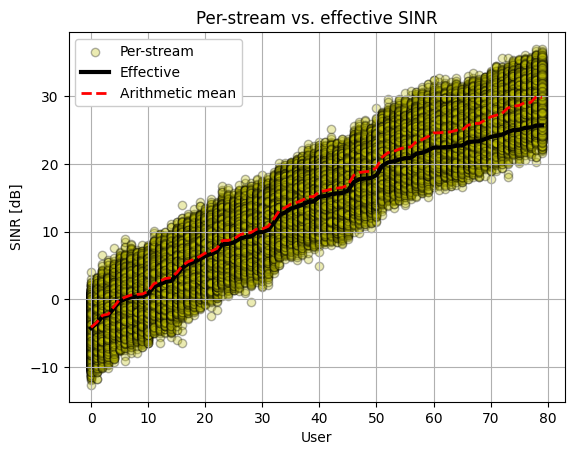

In [26]:
# Sort users in increasing order of effective SINR
ind_sort = np.argsort(sinr_eff)

# [num_ut, num_ofdm_symbols, num_subcarriers, num_streams_per_ut]
sinr_t = np.transpose(sinr.numpy(), [2, 0, 1, 3])
# [num_ut, num_ofdm_symbols*num_subcarriers*num_streams_per_ut]
sinr_t = np.reshape(sinr_t, [num_ut, -1])
sinr_t = sinr_t[ind_sort, :]

# Visualize the effective vs. per-stream SINR values
fig, ax = plt.subplots()
for ut in range(num_ut):
    label = 'Per-stream' if ut==0 else None
    ax.scatter([ut]*sinr_t.shape[1], 10*np.log10(sinr_t[ut, :]), c='y', alpha=.3, edgecolors='k', label=label)
ax.plot(10*np.log10(sinr_eff[ind_sort]), '-k', linewidth=3, label='Effective')
ax.plot(10*np.log10(sinr_t.mean(axis=1)), '--r', linewidth=2, label='Arithmetic mean')
ax.set_xlabel('User')
ax.set_ylabel('SINR [dB]')
ax.set_title('Per-stream vs. effective SINR')
ax.grid()
ax.legend(framealpha=1)
plt.show()

We observe that for users in good channel conditions, the effective SINR shifts
to lower percentiles of the per-stream SINR distribution due to the exponent's
effect, which attenuates high per-stream SINR values.  
In other words, at low average SINR, the effective SINR is close to the arithmetic mean of the per-stream SINR values, whereas at high SINR, it is significantly lower than the average per-stream SINR.

### Achieved vs. Shannon spectral efficiency

Finally, we compute the achieved spectral efficiency and compare it against the
corresponding Shannon upper bound, for each user.

In [27]:
# Determine if a resource element carries energy from at 
# least one stream of a particular user
# [num_ofdm_sym, num_subcarriers, num_ut]
is_re_allocated = np.sum(sinr.numpy(), axis=-1) > 0

# Sum the number of allocated resource elements across
# all subcarriers and OFDM symbols
# [num_ut]
num_allocated_re = np.sum(is_re_allocated, axis=(-2, -3))

# Achieved spectral efficiency
# number of decoded bits of the transport block divided by the number of
# allocated resource elements
# [num_ut]
se_achieved = num_decoded_bits / num_allocated_re

# Shannon capacity
# [num_ut]
se_shannon = log2(tf.cast(1, sinr_eff.dtype) + sinr_eff)

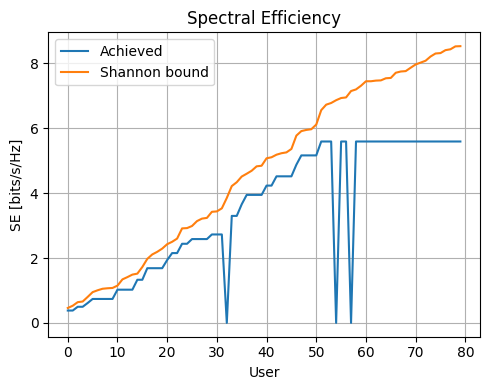

In [28]:
def get_cdf(values):
    """
    Computes the Cumulative Distribution Function (CDF) of the input vector
    """
    values = np.array(values).flatten()
    n = len(values)
    sorted_val = np.sort(values)
    cumulative_prob = np.arange(1, n+1) / n
    return sorted_val, cumulative_prob

fig, ax = plt.subplots(figsize=(5,4))
ind_sort = np.argsort(se_shannon.numpy())
ax.plot(se_achieved.numpy()[ind_sort], label='Achieved')
ax.plot(se_shannon.numpy()[ind_sort], label='Shannon bound')
ax.set_title('Spectral Efficiency')
ax.set_xlabel('User')
ax.set_ylabel('SE [bits/s/Hz]')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

One can see that the achieved spectral efficiency is substantially lower
than the Shannon capacity. At low SINR, this is mainly due to the fact that the targeted BLER
limits the achievable spectral efficiency. At high SINR, the highest available MCS scheme is the
main limiting factor. A zero spectral efficiency is observed when the transport
block has not been decoded correctly, which occurs with probability TBLER.

You can play around with different BLER targets, MCS indices, tables, and
resource grid sizes (i.e., number of OFDM symbols and subcarriers) to observe their impact on the achieved spectral efficiency.

## Conclusions

The [PHYAbstraction](https://nvlabs.github.io/sionna/sys/api/abstraction.html#sionna.sys.PHYAbstraction) class bypasses the physical layer processing via the
computation of an AWGN-equivalent effective SINR which is mapped to a BLER value
according to precomputed tables.

In this notebook, the SINR generation and MCS selection processes are
intentionally simplified.  
For a deeper understanding of these topics, you can have a look at the following notebooks:

- SINR computation from OFDM channel matrices is covered in the 
  [hexagonal grid topology notebook](https://nvlabs.github.io/sionna/sys/tutorials/HexagonalGrid.html);
- Link adaptation for MCS selection is discussed in the 
  [link adaptation notebook](https://nvlabs.github.io/sionna/sys/tutorials/LinkAdaptation.html).

## References

[1] S. Lagen, K. Wanuga, H. Elkotby, S. Goyal, N. Patriciello, L.
    Giupponi. *New radio physical layer abstraction for
    system-level simulations of 5G networks*. IEEE International
    Conference on Communications (ICC), 2020 
